# PSET 4

### Juan M Jimenez R.

## Question 2
### Part A

In [1]:
#using Pkg
#Pkg.add(["Distributions", "Random", "PrettyTables", "QuadGK", "Plots", "Roots", "JLD2"])

using Distributions, Random, PrettyTables, QuadGK, Plots, Roots, JLD2

In [2]:
#Creating the numerical integration function 
function numProb(c,α) 
   
    χ_crit = quantile(Chisq(1), 1-α)
    prob= quadgk(z -> ((z+c)^2>χ_crit)*pdf(Normal(0,1),z), -Inf, Inf, atol=1e-8)[1]
    
    return prob
end

numProb (generic function with 1 method)

### Part B 

In [3]:
#Creating the probability function with built in command 
function builtinProb(c,α) 
   
    χ_crit = quantile(Chisq(1), 1-α)
    prob= 1 - cdf(NoncentralChisq(1,c^2), χ_crit)[1]
    
    return prob
end

builtinProb (generic function with 1 method)

In [4]:
store1=zeros(100,2)
store2=zeros(100,2)
c=zeros(100,1)

for i=1:100
    c[i]=0.1*i
    store1[i,1]=numProb(c[i],0.05)
    store2[i,1]=builtinProb(c[i],0.05)
    store1[i,2]=@elapsed numProb(c[i],0.05)
    store2[i,2]= @elapsed builtinProb(c[i],0.05)
end 

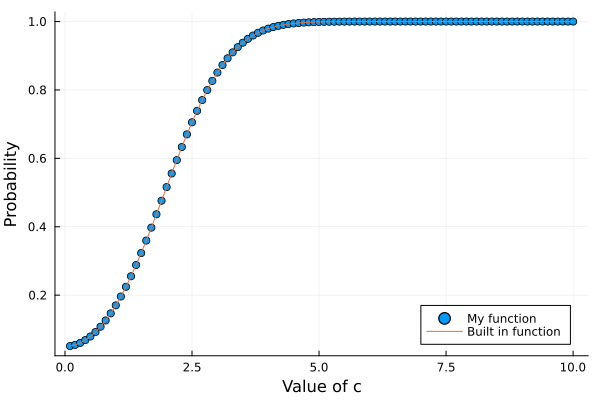

In [5]:
scatter(c, store1[:,1], label="My function", legend=:bottomright)
plot!(c, store2[:,1], label="Built in function ")
plot!(xlabel="Value of c", ylabel="Probability")

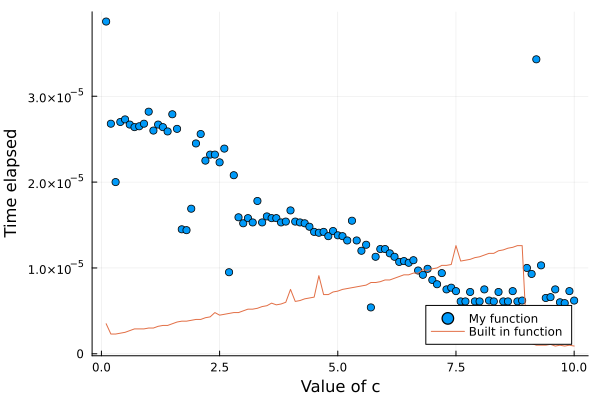

In [6]:
scatter(c, store1[:,2], label="My function", legend=:bottomright)
plot!(c, store2[:,2], label="Built in function ")
plot!(xlabel="Value of c", ylabel="Time elapsed")

As it can be seen from the plots, both functions give similar results when calculating the probability. It seems that the function `numProb` is almost always slower than `builtinProb`. However, at some values of the centrality paramter it turns out that the `numProb` is faster. 

### Part C

In [7]:
find_zero( c -> 0.8-builtinProb(c,0.05), (0,10), atol=1e-10)

2.8015817871962554

The non-centrality parameter for π=0.8 with α=0.05 is approximately 2.8

## Question 3
### Part A

About the hints:
- The relationship between the $z$-test and the $\chi_1$-test (1 degree of freedom) is that the z-dist to the power of 2 is equal to the chi distr. That is why for an $\alpha=5\%$ they generate the same p-value (as I show in the previous lines).
- I will consider the the local alternatives framework: $\theta=\theta_0+\delta/\sqrt{n}$
- I will consider a standard error is $std.err_n=\hat{w}_n/\sqrt{n}$

#### Answer:
- The power of the test we want to test is $P((\sqrt{n}(\hat{\theta}_n-\theta_0)/w)^2 >\chi^2_{1,1-\alpha})$
- This can be separated into $P((\sqrt{n}(\hat{\theta}_n-\theta)/w  +  \sqrt{n}(\theta-\theta_0)/w)^2 >\chi^2_{1,1-\alpha})$
- Where the first term is a st-normal(0,1) and the second term is equal to $\delta/w$
- Therefore we can rewrite the power of the test as $P((z+\delta/w)^2 >\chi^2_{1,1-\alpha})$, or
- We can write it as $P((z+|c|)^2 >\chi^2_{1,1-\alpha})$
- So we have that the relationship between the noncentralized parameter and the MDE is the following:

$$|c^*|=|\delta/\hat{w}_n|=|\sqrt{n}*(MDE-\theta_0)/\hat{w}_n|$$

Solving for MDE we have the following relationship:

#### Equation 1:
$$MDE=(|c^*|*\hat{w}_n)/\sqrt{n}$$ 

where 
- $c^*=c(\alpha,\pi)$
- $MDE=\theta(\alpha,\pi,n)$
- $\hat{w}_n$ is the estimate of $w$

And finally, we have that:

#### Equation 2:
$$ \pi = P((z+|c^*|)^2 >\chi^2_{1,1-\alpha}) $$


Therefore,the MDE is directly proportional to the non centrality parameter. In addition, we can get the value of $|c^*|$ from Equation 2, and then we can calculate the MDE with Equation 1. 

### Part B

In [8]:
F = jldopen("627_ps_04-23-3-data.jld2")

JLDFile C:\Github\ubc-phd\627-metrics-II\627_ps_04-23-3-data.jld2 (read-only)
 ├─🔢 Y
 ├─🔢 X1
 ├─🔢 X2
 └─🔢 Z1

In [9]:
Y=F["Y"];
X1=F["X1"];
X2=F["X2"];
Z1=F["Z1"];

### Part C

In [10]:
#MDE function (equation 1)
function mdeCal(α,π,n,w)
    
    cstar = find_zero( c -> π-builtinProb(c,α), (0,10), atol=1e-10)
    mde = cstar*w/sqrt(n)
    
    return mde
end    

#N size function (equation 2)
function n_size(α,π,MDE,w)
    
    size = find_zero(n->MDE-mdeCal(α,π,n,w),(0,10^5), atol=1e-10)
    
    return size
end

#Z-test function 
function ztest(β, σ, α) 
    
    z = β/σ
    #z_α = quantile(Normal(), 1- α/2)
    pz = 2*(1-cdf(Normal(0,1), z))
    
    if pz <= α
        
        print("Rejects the null at α=", α*100, "%, t-stat=", z, "p-value=", pz)
        
    else
        
        print("Cannot reject the null at α=", α*100, "%, t-stat=", z, "p-value=", pz)
    end
    
    return z, pz
end

ztest (generic function with 1 method)

In [11]:
#2SLS estimation function 
function est2sls(Y,X,Z)
       
    #Estimator
    PZ = Z*( (Z'*Z)\Z' )
    β2sls = (X'*PZ*X)\(X'*PZ*Y)
    
    #Calculating Ω
    U= Y - X*β2sls
    n=length(U)
    #Ω= (Z'*U*U'Z)./n
    zr = Z.*U
    Ω = (zr' * zr)/n
    
    #Standard error
    Q= (Z'*X)./n
    W= inv((Z'*Z)./n)
    σ2_2sls= ( (Q'*W*Q)\(Q'*W*Ω*W*Q)/(Q'*W*Q) )./n
    σ_2sls= sqrt(σ2_2sls)
    
    return β2sls, σ_2sls
end

est2sls (generic function with 1 method)

In [12]:
#Using only the first n=100 observations
Ys=Y[1:100] 
X1s=X1[1:100]
X2s=X2[1:100,:]
Z1s=Z1[1:100,:]

Xs=[X1s X2s]
Zs=[Z1s X2s]

beta, std = est2sls(Ys, Xs, Zs)
est=[beta[1] std[1]]

1×2 Matrix{Float64}:
 0.113219  0.151452

In [13]:
#Checking significance 
ztest(beta[1], std[1], 0.05);

Cannot reject the null at α=5.0%, t-stat=0.7475560217758441p-value=0.45472799979143463

In [14]:
#Computing MDE
n=100
mdes=mdeCal(0.05,0.8,n,std[1]*sqrt(n))  
#Multiplying by n^1/2 bc stderr(betahat-beta)=w/n^1/2 and we want stderr(betahat)=w

0.4243054825891523

In [15]:
#Computing the sample size fot he MDE we found
mdes=0.2
n_size(0.05,0.8,mdes,std[1]*sqrt(100))

450.087855960076

### Part D

In [16]:
X=[X1 X2]
Z=[Z1 X2]

beta, std = est2sls(Y, X, Z)
est=[beta[1] std[1]]

1×2 Matrix{Float64}:
 0.191256  0.0590087

In [17]:
#Checking significance 
ztest(beta[1], std[1], 0.05);

Rejects the null at α=5.0%, t-stat=3.2411524630364776p-value=0.0011904749479421106

In [18]:
#Computing MDE
n=1000
mdes=mdeCal(0.05,0.8,n,std[1]*sqrt(n))  

0.16531764527119314

### Part E